<a href="https://colab.research.google.com/github/wanessamendonca/Projeto_NLP/blob/main/case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importando Bibliotecas**

In [ ]:
# Bibliotecas clássicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [ ]:
# Bibliotecas para pré-processamento de texto
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from wordcloud import WordCloud
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Download do vocabulário em pt-BR
spacy.cli.download("pt_core_news_sm")

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
# Download do stemmizador
nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
# Bibliotecas para tokenização de texto
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Bibliotecas para implementação de RNN
from keras.layers import Embedding, Input, Dropout, LSTM, Dense, SpatialDropout1D, Bidirectional, Conv1D
import tensorflow as tf

## **Importando o Dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Santander Coders/Case PLN/2019-05-28_portuguese_hate_speech_binary_classification.csv')
df.head()

,text,hatespeech_comb,hatespeech_G1,annotator_G1,hatespeech_G2,annotator_G2,hatespeech_G3,annotator_G3
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1,1,A,1.0,V,0,E
1,@_carmeloneto Estes incompetentes não cuidam n...,0,1,D,0.0,V,0,C
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0,1,A,0.0,B,0,E
3,@_GlitteryKisses é isso não conseguem pensar n...,0,0,C,0.0,V,0,D
4,@_iglira bom dia macaco branco haha,1,0,A,1.0,I,1,E


## **Checando principais Informações e Aplicando Tratamentos**

In [ ]:
# Checando a dimensão da base de dados
df.shape

(5670, 8)

In [ ]:
# Checando a presença de valores faltantes
df.isnull().sum()

text               0
hatespeech_comb    0
hatespeech_G1      0
annotator_G1       0
hatespeech_G2      2
annotator_G2       0
hatespeech_G3      0
annotator_G3       0
dtype: int64

In [ ]:
# Checando se existem linhas duplicadas
df.duplicated().sum()

4

In [ ]:
# Eliminando as linhas duplicadas
df = df.drop_duplicates()

In [ ]:
# Checando a nova dimensão da base de dados
df.shape

(5666, 8)

In [ ]:
# Reduzindo o dataset apenas ao texto e à classificação combinada
df = df.loc[:, ['text','hatespeech_comb']]

## **Checando a Distribuição dos Dados**

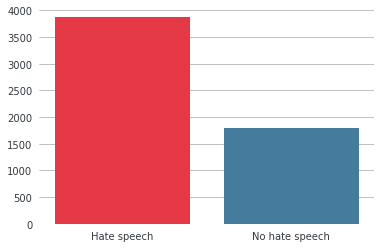

In [ ]:
fig, ax = plt.subplots()
ax.bar(['Hate speech', 'No hate speech'], df['hatespeech_comb'].value_counts(), color = ['#E63946', '#457B9D'])
ax.set_axisbelow(True)
ax.grid(True, axis = 'y')

for location in ['top', 'bottom', 'left', 'right']:
    ax.spines[location].set_visible(False)
    
plt.xticks(fontsize = 10, color = '#343A40')
plt.yticks(fontsize = 10, color = '#343A40')
ax.tick_params(color = 'white')

Como podemos observar, os dados não estão balanceados - o número de tweets classificados como discurso de ódio é quase o dobro daqueles que não representam falas de ódio. 

Uma forma de contornar esta situação sem perder informações, é realizar um oversampling para a classe que está em menor quantidade, no caso, tweets que não são discurso de ódio, direcionado para os dados de **treino**, o que será aplicado mais adiante no projeto.

## **Pré-processamento e Distinção entre Conjuntos de Dados**

**1ª fase:** Nesta etapa iremos converter o texto para caracteres minúsculos, retirar pontuações, números, espaços e stop words. Além disso, por se tratarem de tweets, é interessante remover os nomes de usuário e hiperlinks via regex.

In [ ]:
# Importando as stopwords
stop_words = set(stopwords.words("portuguese"))

# Definindo nlp
nlp = spacy.load('pt_core_news_sm')

# Regex para retirar nomes de usuário, hiperlinks e números
text_regex = "@\S+|https?:\S+|http?:\S|[0-9]" 

In [ ]:
# Construindo a função de pré-processamento
def processing_text(text):

  # Retirando o \n (novo parágrafo)
  text = text.replace('\n',' ')

  # Retirando espaços
  text = text.strip()
  
  # Fazendo remoções pela regex e convertendo para minúsculo
  text = re.sub(text_regex, ' ', str(text).lower())

  # Fazendo a tokenização do texto (transformação p/ objeto token)
  text = nlp(text)

  # Retirando a pontuação
  text_clean = [token.orth_ for token in text if not token.is_punct]

  # Retirando as stop words
  text_clean = [word for word in text_clean if word not in stop_words]

  return ' '.join(text_clean)

In [ ]:
# Aplicando ao dataset
df.text = df.text.apply(processing_text)

In [ ]:
df.head()

,text,hatespeech_comb
0,cara vive outro mundo mundo real refugiado...,1
1,incompetentes cuidam povo brasileiro poucos...,0
2,cumpanhero quebraram todas regras,0
3,conseguem pensar sentido lato além vê frent...,0
4,bom dia macaco branco haha,1


In [ ]:
# Salvando os tweets pré-processados em um csv
df.to_csv('/content/drive/MyDrive/Santander Coders/Case PLN/clean_tweets.csv')

**2ª fase:** Nesta etapa um conjunto de treino será separado para que posteriormente a ele seja aplicada as transformações e a configuração de modelo com melhor desempenho. Esta seleção será feita com base nos conjuntos de validação a serem gerados adiante.

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42)

print(f'Dimensões do conjunto de treino: {train_data.shape}')
print(f'Dimensões do conjunto de teste: {test_data.shape}')

Dimensões do conjunto de treino: (4532, 2)
Dimensões do conjunto de teste: (1134, 2)


**3ª fase:** Nesta última etapa, iremos gerar quatro conjuntos de dados seguindo diferentes condições para encontrar os radicais das palavras:
- Um conjunto lematizado e stemizado (`df_1`);
- Um conjunto apenas stemizado (`df_2`);
- Um conjunto lematizado (`df_3`);
- Um conjunto sem nenhum tipo de transformação neste sentido (`df_4`).

In [ ]:
# Iniciando o objeto para stemização
stemmer = SnowballStemmer('portuguese')

# Definindo as funções de lematização e stemização:
def lemmatiza(text):
  tokens = nlp(text)
  tokens = [token.lemma_ for token in tokens]
  return ' '.join(tokens)

def stemmiza(text):
  words = [stemmer.stem(word) for word in text.split()]
  return ' '.join(words)  

In [ ]:
# Conjunto lematizado/stemizado
df_1 = train_data.copy()
df_1.text = df_1.text.apply(lemmatiza)
df_1.text = df_1.text.apply(stemmiza)

In [ ]:
# Conjunto stemizado
df_2 = train_data.copy()
df_2.text = df_2.text.apply(stemmiza)

In [ ]:
# Conjunto lematizado
df_3 = train_data.copy()
df_3.text = df_3.text.apply(lemmatiza)

In [ ]:
# Conjunto sem transformações
df_4 = train_data.copy()

## **Wordcloud**

Antes de prosseguirmos com a implementação de modelos, é interessante observarmos quais palavras estão presentes em maior frequência nos tweets classificados como discurso de ódio.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Santander Coders/Case PLN/clean_tweets.csv')

In [ ]:
# Função para mudar as cores das palavras:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    list_colors = ['#B7094C','#A01A58','#892B64','#723C70','#5C4D7D','#455E89','#2E6F95','#1780A1','#0091AD']
    np.random.seed(42)
    color = random.choice(list_colors)

    return color

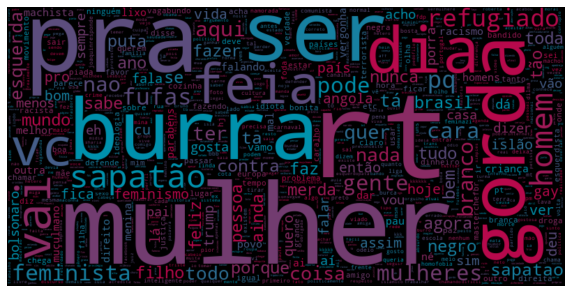

In [ ]:
hate_texts = ' '.join((df.loc[df['hatespeech_comb'] == 1, 'text']).to_list())
word_cloud = WordCloud(max_words=2000, width = 800, height = 400, color_func = random_color_func, collocations = False).generate(hate_texts)

plt.figure(figsize=(10,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Embora estejam presentes muitas palavras comuns e muito utilizadas no português ("pra", "ser", "vc"), percebe-se que **a maior parte dos tweets classifcados como discurso de ódio possuem como alvo o público feminino**.

## **Transformando Textos em Sequências Numéricas**

Antes de implementarmos um modelo de redes neurais, devemos transformar cada tweet em uma sequência de números utilizando o tokenizador da biblioteca keras.

In [ ]:
# Verificando o tamanho máximo entre todos os tweets
print(max(df.text.apply(len)))

131


In [ ]:
# A primeira etapa deve ser dividir os datasets em treino e teste, uma vez que a tokenização deve ocorrer no treino e ser aplicada ao teste.
max_nb_words = 1000000
max_seq_length = 131

train_data_1, val_data_1 = train_test_split(df_1, test_size = 0.2, random_state = 42)
train_data_2, val_data_2 = train_test_split(df_2, test_size = 0.2, random_state = 42)
train_data_3, val_data_3 = train_test_split(df_3, test_size = 0.2, random_state = 42)
train_data_4, val_data_4 = train_test_split(df_4, test_size = 0.2, random_state = 42)

Conforme afirmado anteriormente, a fim de evitar a má performance do modelo ou a diminuição de sua capacidade aprendizado, um oversampling da classe minoritária deve ser feito nos dados de treinamento, para cada um dos datasets criados.

A técnica de Random Over Sampling será utilizada.

In [ ]:
# Conjunto 1 - Stemizado/Lematizado
X_1 = np.array(train_data_1['text']).reshape(-1,1)
y_1 = train_data_1['hatespeech_comb']
ros_1 = RandomOverSampler(random_state = 42)
X_resampled_1, y_resampled_1 = ros_1.fit_resample(X_1,y_1)

In [ ]:
train_data_1 = pd.DataFrame(X_resampled_1, y_resampled_1).reset_index()
train_data_1.columns = ['hatespeech_comb', 'text']
train_data_1.head(3)

,hatespeech_comb,text
0,0,val pen ler text ronald laranjeir show
1,0,fã d mulh cozinh telh masterchefbr
2,0,agor sim lisbo pront comec


In [ ]:
# Conjunto 2 - Stemizado
X_2 = np.array(train_data_2['text']).reshape(-1,1)
y_2 = train_data_2['hatespeech_comb']
ros_2 = RandomOverSampler(random_state = 42)
X_resampled_2, y_resampled_2 = ros_2.fit_resample(X_2,y_2)

In [ ]:
train_data_2 = pd.DataFrame(X_resampled_2, y_resampled_2).reset_index()
train_data_2.columns = ['hatespeech_comb', 'text']
train_data_2.head(3)

,hatespeech_comb,text
0,0,val pen ler text ronald laranjeir show
1,0,fã d mulh cozinh telh masterchefbr
2,0,agor sim lisbo pront comec


In [ ]:
# Conjunto 3 - Lematizado
X_3 = np.array(train_data_3['text']).reshape(-1,1)
y_3 = train_data_3['hatespeech_comb']
ros_3 = RandomOverSampler(random_state = 42)
X_resampled_3, y_resampled_3 = ros_3.fit_resample(X_3,y_3)

In [ ]:
train_data_3 = pd.DataFrame(X_resampled_3, y_resampled_3).reset_index()
train_data_3.columns = ['hatespeech_comb', 'text']
train_data_3.head(3)

,hatespeech_comb,text
0,0,valer peno ler texto ronaldo laranjeira show
1,0,fã d mulher cozinhar telhar masterchefbr
2,0,agora sim lisboa pronto começar


In [ ]:
# Conjunto 4 - Sem tranformações
X_4 = np.array(train_data_4['text']).reshape(-1,1)
y_4 = train_data_4['hatespeech_comb']
ros_4 = RandomOverSampler(random_state = 42)
X_resampled_4, y_resampled_4 = ros_4.fit_resample(X_4,y_4)

In [ ]:
train_data_4 = pd.DataFrame(X_resampled_4, y_resampled_4).reset_index()
train_data_4.columns = ['hatespeech_comb', 'text']
train_data_4.head(3)

,hatespeech_comb,text
0,0,vale pena ler texto ronaldo laranjeiras show
1,0,fã d mulher cozinha telha masterchefbr
2,0,agora sim lisboa prontos começar


Com os dados de treino devidamente balanceados em relação às diferentes classes, seguimos para tokenização via keras: 

In [ ]:
# Tokenizando as palavras do vocabulário para o Conjunto Lematizado e Stemizado (1)
tokenizer_1 = Tokenizer()
tokenizer_1.fit_on_texts(train_data_1.text)
word_index_1 = tokenizer_1.word_index 
vocab_size_1 = len(word_index_1) + 1
print(f'Tamanho do vocabulário para o Conjunto 1: {vocab_size_1}')

Tamanho do vocabulário para o Conjunto 1: 5998


In [ ]:
# Gerando as sequências (com padding)
x_train_1 = pad_sequences(tokenizer_1.texts_to_sequences(train_data_1.text), maxlen = max_seq_length)
x_val_1 = pad_sequences(tokenizer_1.texts_to_sequences(val_data_1.text), maxlen = max_seq_length)
print(f'Dimensões do Conjunto de treino 1: {x_train_1.shape}')
print(f'Dimensões do Conjunto de validação 1: {x_val_1.shape}')

Dimensões do Conjunto de treino 1: (4956, 131)
Dimensões do Conjunto de validação 1: (907, 131)


In [ ]:
# Separando as variáveis alvo
y_train_1 = train_data_1.hatespeech_comb
y_val_1 = val_data_1.hatespeech_comb

In [ ]:
# Tokenizando as palavras do vocabulário para o Conjunto Stemizado (2)
tokenizer_2 = Tokenizer()
tokenizer_2.fit_on_texts(train_data_2.text)
word_index_2 = tokenizer_2.word_index 
vocab_size_2 = len(word_index_2) + 1
print(f'Tamanho do vocabulário para o Conjunto 2: {vocab_size_2}')

Tamanho do vocabulário para o Conjunto 2: 6392


In [ ]:
# Gerando as sequências (com padding)
x_train_2 = pad_sequences(tokenizer_2.texts_to_sequences(train_data_2.text), maxlen = max_seq_length)
x_val_2 = pad_sequences(tokenizer_2.texts_to_sequences(val_data_2.text), maxlen = max_seq_length)
print(f'Dimensões do Conjunto de treino 2: {x_train_2.shape}')
print(f'Dimensões do Conjunto de validação 2: {x_val_2.shape}')

Dimensões do Conjunto de treino 2: (4956, 131)
Dimensões do Conjunto de validação 2: (907, 131)


In [ ]:
# Separando as variáveis alvo
y_train_2 = train_data_2.hatespeech_comb
y_val_2 = val_data_2.hatespeech_comb

In [ ]:
# Tokenizando as palavras do vocabulário para o Conjunto Lematizado (3)
tokenizer_3 = Tokenizer()
tokenizer_3.fit_on_texts(train_data_3.text)
word_index_3 = tokenizer_3.word_index 
vocab_size_3 = len(word_index_3) + 1
print(f'Tamanho do vocabulário para o Conjunto 3: {vocab_size_3}')

Tamanho do vocabulário para o Conjunto 3: 6771


In [ ]:
# Gerando as sequências (com padding)
x_train_3 = pad_sequences(tokenizer_3.texts_to_sequences(train_data_3.text), maxlen = max_seq_length)
x_val_3 = pad_sequences(tokenizer_3.texts_to_sequences(val_data_3.text), maxlen = max_seq_length)
print(f'Dimensões do Conjunto de treino 3: {x_train_3.shape}')
print(f'Dimensões do Conjunto de validação 3: {x_val_3.shape}')

Dimensões do Conjunto de treino 3: (4956, 131)
Dimensões do Conjunto de validação 3: (907, 131)


In [ ]:
# Separando as variáveis alvo
y_train_3 = train_data_3.hatespeech_comb
y_val_3 = val_data_3.hatespeech_comb

In [ ]:
# Tokenizando as palavras do vocabulário para o Conjunto sem Transformações (4)
tokenizer_4 = Tokenizer()
tokenizer_4.fit_on_texts(train_data_4.text)
word_index_4 = tokenizer_4.word_index 
vocab_size_4 = len(word_index_4) + 1
print(f'Tamanho do vocabulário para o Conjunto 4: {vocab_size_4}')

Tamanho do vocabulário para o Conjunto 4: 9367


In [ ]:
# Gerando as sequências (com padding)
x_train_4 = pad_sequences(tokenizer_4.texts_to_sequences(train_data_4.text), maxlen = max_seq_length)
x_val_4 = pad_sequences(tokenizer_4.texts_to_sequences(val_data_4.text), maxlen = max_seq_length)
print(f'Dimensões do Conjunto de treino 4: {x_train_4.shape}')
print(f'Dimensões do Conjunto de teste 4: {x_val_4.shape}')

Dimensões do Conjunto de treino 4: (4956, 131)
Dimensões do Conjunto de teste 4: (907, 131)


In [ ]:
# Separando as variáveis alvo
y_train_4 = train_data_4.hatespeech_comb
y_val_4 = val_data_4.hatespeech_comb

## **Implementando o Modelo de Redes Neurais Recorrentes**

A primeira etapa deve ser a construção do layer de **Embedding**:

In [ ]:
embedding_layer_1 = Embedding(input_dim = vocab_size_1, output_dim = 80, input_length = max_seq_length)

Tendo o layer de embedding, implementamos então um modelo funcional, em que a etapa posterior depende da etapa anterior.

A seguinte arquitetura será seguida:
- Layer de embedding;
- Layer de dropout do embedding;
- Implementação de recorrência via LSTM - *Long Short Term Memory* - (com dropout e dropout recorrente);
- Layer Denso;
- Dropout do layer denso;
- Layer denso de output com função de ativação sigmoide, devido ao tipo de classificação.

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer_1(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_1 = tf.keras.Model(sequence_input, outputs)

Resumo dos parâmetros do modelo:

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 131)]             0         
                                                                 
 embedding (Embedding)       (None, 131, 80)           479840    
                                                                 
 spatial_dropout1d (SpatialD  (None, 131, 80)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                37120     
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 1024
epochs = 20
history_1 = model_1.fit(x_train_1, y_train_1, batch_size = batch_size, epochs = epochs, validation_data = (x_val_1, y_val_1))

Epoch 1/20
5/5 [==============================] - 11s 2s/step - loss: 0.6925 - accuracy: 0.5365 - val_loss: 0.6884 - val_accuracy: 0.6516
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 0.6885 - accuracy: 0.5910 - val_loss: 0.6729 - val_accuracy: 0.6880
Epoch 3/20
5/5 [==============================] - 7s 1s/step - loss: 0.6770 - accuracy: 0.6437 - val_loss: 0.6612 - val_accuracy: 0.6681
Epoch 4/20
5/5 [==============================] - 8s 2s/step - loss: 0.6480 - accuracy: 0.7010 - val_loss: 0.6260 - val_accuracy: 0.6946
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 0.5891 - accuracy: 0.7504 - val_loss: 0.5834 - val_accuracy: 0.7144
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 0.4886 - accuracy: 0.8039 - val_loss: 0.5724 - val_accuracy: 0.7012
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.3742 - accuracy: 0.8600 - val_loss: 0.5723 - val_accuracy: 0.7266
Epoch 8/20
5/5 [========================

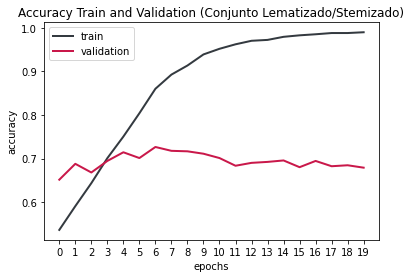

In [ ]:
plt.title('Accuracy Train and Validation (Conjunto Lematizado/Stemizado)')
plt.plot(history_1.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_1.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

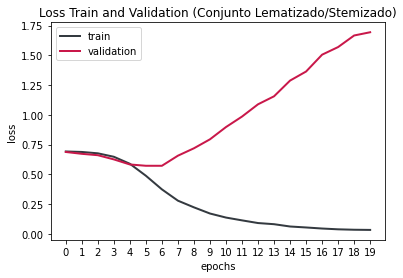

In [ ]:
plt.title('Loss Train and Validation (Conjunto Lematizado/Stemizado)')
plt.plot(history_1.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_1.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Vamos agora aplicar as mesmas etapas para o conjunto de dados apenas stemizado:

In [ ]:
embedding_layer_2 = Embedding(input_dim = vocab_size_2, output_dim = 80, input_length = max_seq_length)

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer_2(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_2 = tf.keras.Model(sequence_input, outputs)

In [ ]:
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 131)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 131, 80)           511360    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 131, 80)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                37120     
                                                                 
 dense_2 (Dense)             (None, 512)               33280     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
history_2 = model_2.fit(x_train_2, y_train_2, batch_size = batch_size, epochs = epochs, validation_data = (x_val_2, y_val_2), verbose = 0)

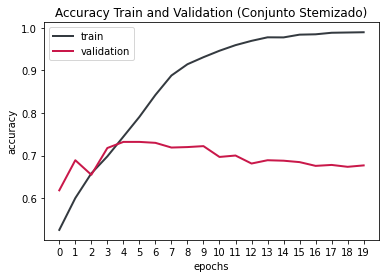

In [ ]:
plt.title('Accuracy Train and Validation (Conjunto Stemizado)')
plt.plot(history_2.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_2.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

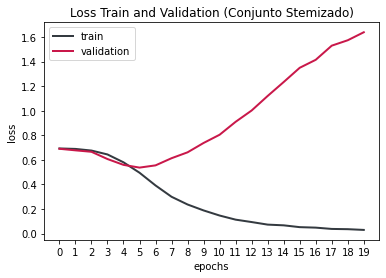

In [ ]:
plt.title('Loss Train and Validation (Conjunto Stemizado)')
plt.plot(history_2.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_2.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Implementando o modelo para o conjunto de dados lematizado:

In [ ]:
embedding_layer_3 = Embedding(input_dim = vocab_size_3, output_dim = 80, input_length = max_seq_length)

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer_3(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_3 = tf.keras.Model(sequence_input, outputs)

In [ ]:
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 131)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 131, 80)           541680    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 131, 80)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                37120     
                                                                 
 dense_4 (Dense)             (None, 512)               33280     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
history_3 = model_3.fit(x_train_3, y_train_3, batch_size = batch_size, epochs = epochs, validation_data = (x_val_3, y_val_3), verbose = 0)

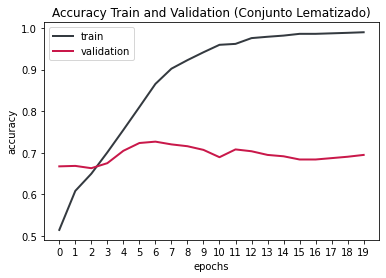

In [ ]:
plt.title('Accuracy Train and Validation (Conjunto Lematizado)')
plt.plot(history_3.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_3.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

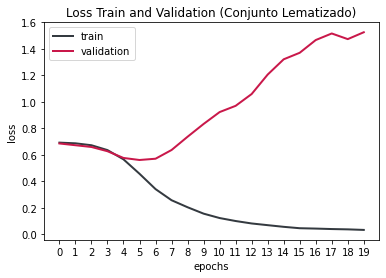

In [ ]:
plt.title('Loss Train and Validation (Conjunto Lematizado)')
plt.plot(history_3.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_3.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Implementando o modelo para o conjunto de dados que não sofreu nenhuma tranformação em termos de lematização/stemização:

In [ ]:
embedding_layer_4 = Embedding(input_dim = vocab_size_4, output_dim = 80, input_length = max_seq_length)

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer_4(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_4 = tf.keras.Model(sequence_input, outputs)

In [ ]:
model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 131)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 131, 80)           749360    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 131, 80)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 64)                37120     
                                                                 
 dense_6 (Dense)             (None, 512)               33280     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                           

In [ ]:
history_4 = model_4.fit(x_train_4, y_train_4, batch_size = batch_size, epochs = epochs, validation_data = (x_val_4, y_val_4), verbose = 0)

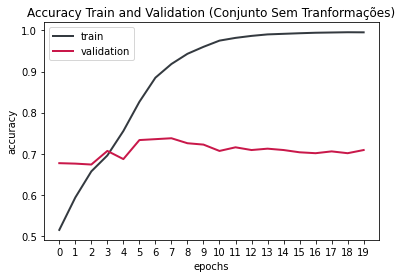

In [ ]:
plt.title('Accuracy Train and Validation (Conjunto Sem Tranformações)')
plt.plot(history_4.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_4.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

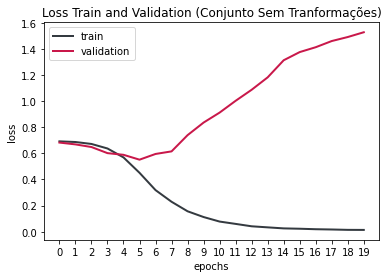

In [ ]:
plt.title('Loss Train and Validation (Conjunto Sem Tranformações)')
plt.plot(history_4.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_4.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Resumo sobre o desempenho dos modelos
models = ['Stemizado/Lematizado',
          'Stemizado',
          'Lematizado',
          'Sem Transformações']

accuracy = [history_1.history['val_accuracy'][-1],
            history_2.history['val_accuracy'][-1],
            history_3.history['val_accuracy'][-1],
            history_4.history['val_accuracy'][-1]]

results = pd.DataFrame({'Conjunto Utilizado': models,
                        'Acurácia na Validação': accuracy})

results['Acurácia na Validação'] = results['Acurácia na Validação'].apply(lambda x: round(x, 4))

display(results)

,Conjunto Utilizado,Acurácia na Validação
0,Stemizado/Lematizado,0.6792
1,Stemizado,0.6770
2,Lematizado,0.6946
3,Sem Transformações,0.7089


Dentre os resultados obtidos, é possível perceber que a RNN treinada com um conjunto de dados sem transformações foi a que obteve o melhor desempenho. As operações de lematização e stemização podem ter ocasionado em perca de sentido, o que pode em certa medida justificar as métricas obtidas.

Redes Neurais por si só tendem a ser sistemas complexos e com grande possibilidade de *overfitting* a depender da arquitetura. Com base na análise dos gráficos de acurácia e da função de perda, pode-se afirmar que a maior parte dos modelos só apresentou grande disparidade entre os resultados obtidos para os conjuntos de treino e validação a partir do 5º epoch, em média.

## **Implementação de Modelo RNN com LSTM Bidirecional**

Iremos utilizar o conjunto de dados sem transformações para treinamento de uma rede neural recorrente utilizando um LSTM Bidirecional.

Neste tipo de arquitetura, os dados de entrada (no caso tweets que foram convertidos em sequências numéricas) são absorvidos pelo modelo de duas formas: no sentido direto e reverso, a fim de que a rede possa aprender a relação entre palavras passadas e futuras. Optou-se aqui por manter a concatenação dos *outputs* resultantes das leituras em ambas as direções.

In [ ]:
embedding_layer = Embedding(input_dim = vocab_size_4, output_dim = 80, input_length = max_seq_length)

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_bidirectional = tf.keras.Model(sequence_input, outputs)

In [ ]:
model_bidirectional.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_bidirectional.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 131)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 131, 80)           749360    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 131, 80)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74240     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 512)               66048     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0   

In [ ]:
history_bidirectional = model_bidirectional.fit(x_train_4, y_train_4, batch_size = batch_size, epochs = epochs, validation_data = (x_val_4, y_val_4), verbose = 0)

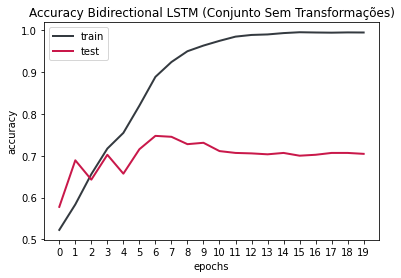

In [ ]:
plt.title('Accuracy Bidirectional LSTM (Conjunto Sem Transformações)')
plt.plot(history_bidirectional.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_bidirectional.history['val_accuracy'], label = 'test', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

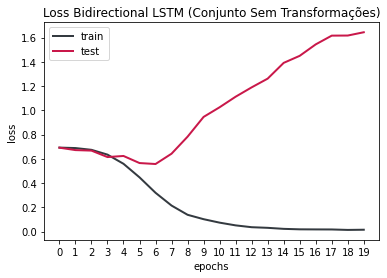

In [ ]:
plt.title('Loss Bidirectional LSTM (Conjunto Sem Transformações)')
plt.plot(history_bidirectional.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_bidirectional.history['val_loss'], label = 'test', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Comparando Resultados
models = ['LSTM Tradicional',
          'LSTM Bidirecional']

accuracy = [history_3.history['val_accuracy'][-1],
            history_bidirectional.history['val_accuracy'][-1]]

results = pd.DataFrame({'Arquitetura': models,
                        'Acurácia na Validação': accuracy})

results['Acurácia na Validação'] = results['Acurácia na Validação'].apply(lambda x: round(x, 4))

display(results)

,Arquitetura,Acurácia na Validação
0,LSTM Tradicional,0.6946
1,LSTM Bidirecional,0.7045


O aumento de complexidade do modelo com a inclusão de um algoritmo bidirecional, decorreu em uma melhora levemente significativa da acurácia na previsão dos resultados quando em comparação com o modelo utilizando o algoritmo LSTM de forma tradicional. Porém, o custo computacional tornou-se maior maior em virtude dos *inputs* - aqui temos duas leituras das sequências.


## **Implementação de Modelo RNN com Convolução**

Ao modelo que vinha sendo executado anteriormente (RNN com LSTM), será incluída uma camada de convolução antes da execução do algoritmo LSTM.

O intuito deste *layer* é diminuir o tempo de treinamento do modelo, isto porque modelos convolucionais tendem a processar os *inputs* de forma simultânea, diferente das redes neurais recorrentes que processam cada palavra de forma sequencial.

A nova arquitetura será dada por:
- Layer de embedding;
- Layer de dropout do embedding;
- Layer de convolução;
- Implementação de recorrência via LSTM - *Long Short Term Memory* - (com dropout e dropout recorrente);
- Layer Denso;
- Dropout do layer denso;
- Layer denso de output com função de ativação sigmoide, devido ao tipo de classificação.

O modelo continuará a ser treinado com o conjunto sem transformações. Para a construção da camada de convolução, uma configuração conservadora foi utilizada.

In [ ]:
embedding_layer = Embedding(input_dim = vocab_size_4, output_dim = 80, input_length = max_seq_length)

In [ ]:
sequence_input = Input(shape = (max_seq_length, ), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(filters = 32, kernel_size = 8, activation = 'relu')(x)
x = LSTM(64, dropout = 0.2, recurrent_dropout = 0.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model_convolutional = tf.keras.Model(sequence_input, outputs)

In [ ]:
model_convolutional.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history_convolutional = model_convolutional.fit(x_train_4, y_train_4, batch_size = batch_size, epochs = epochs, validation_data = (x_val_4, y_val_4), verbose = 0)

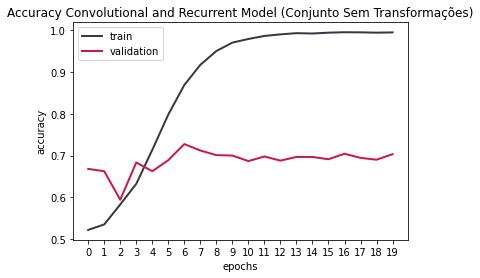

In [ ]:
plt.title('Accuracy Convolutional and Recurrent Model (Conjunto Sem Transformações)')
plt.plot(history_convolutional.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_convolutional.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

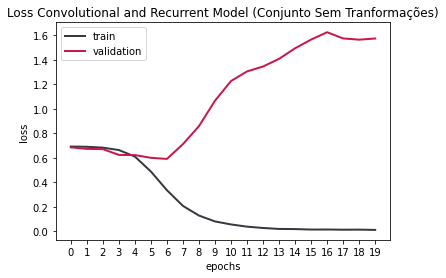

In [ ]:
plt.title('Loss Convolutional and Recurrent Model (Conjunto Sem Tranformações)')
plt.plot(history_convolutional.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_convolutional.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, epochs)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Comparando Resultados
models = ['LSTM Tradicional',
          'LSTM Bidirecional',
          'LSTM c/ Convolução']

accuracy = [history_3.history['val_accuracy'][-1],
            history_bidirectional.history['val_accuracy'][-1],
            history_convolutional.history['val_accuracy'][-1]]

results = pd.DataFrame({'Arquitetura': models,
                        'Acurácia na Validação': accuracy})

results['Acurácia na Validação'] = results['Acurácia na Validação'].apply(lambda x: round(x, 4))

display(results)

,Arquitetura,Acurácia na Validação
0,LSTM Tradicional,0.6946
1,LSTM Bidirecional,0.7045
2,LSTM c/ Convolução,0.7034


A adição de uma camada de convolução de forma prévia à aplicação do algoritmo LSTM não promoveu melhora que fosse significativa quando em comparação com o uso do LSTM de forma tradicional e no formato bidirecional.

De forma geral, pode-se afirmar que as configurações utilizando como dados de treinamento o conjunto sem transformações (lematização e stemização) ofereceram métricas e desempenhos bastante similares.

## **Avaliando o Desempenho da Melhor Configuração nos Dados de Teste**

Nesta etapa, a configuração que proporcionou o alcance da melhor métrica será aplicada aos dados ainda não vistos pelo modelo: 
- Nenhuma transformação em termos de stemização ou lematização será aplicada a estes dados;
- O modelo de RNN com LSTM bidirecional será utilizado.

In [ ]:
# Separando as features e o target
x_test = test_data['text']
y_test = test_data['hatespeech_comb']

# Transformando o input em sequências numéricas
x_test = pad_sequences(tokenizer_4.texts_to_sequences(x_test), maxlen = max_seq_length)

In [ ]:
y_pred = model_bidirectional.predict(x_test)

In [ ]:
y_pred = np.where(y_pred < 0.5, 0, 1)
y_pred

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia alcançada no teste: {accuracy:.4f}')

Acurácia alcançada no teste: 0.7081


A acurácia para dados nunca antes vistos pelo modelo de RNN utilizando LSTM  e convolução mostrou-se bastante similar àquela alcançada com os dados de validação, indicando a qualidade da configuração proposta.